In [2]:
import cv2, glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [6]:
train_anns = glob.glob('./快速现场细胞学评价中的恶性细胞识别挑战赛公开数据/train/labels/*')
train_images = glob.glob('./快速现场细胞学评价中的恶性细胞识别挑战赛公开数据/train/images/*')
train_anns.sort()
train_images.sort()

test_images = glob.glob('./快速现场细胞学评价中的恶性细胞识别挑战赛公开数据/test/images/*')

In [76]:
len(test_images)

18

In [6]:
pd.read_csv(train_anns[0], sep=' ', header=None)

,0,1,2,3,4
0,0,1579,1198,1821,1278
1,1,951,1316,1033,1402
2,1,1294,1439,1400,1534
3,1,1687,697,1795,776
4,1,1561,713,1694,814
...,...,...,...,...,...
63,1,1675,1131,1752,1207
64,1,1089,817,1209,906
65,1,1226,906,1324,975
66,1,1230,638,1292,710


In [7]:
len(train_images), len(test_images)

(72, 18)

In [8]:
plt.figure(dpi=150)
plt.imshow(cv2.imread(train_images[0]))
plt.xticks([]); plt.yticks([]);
ax = plt.gca()

for row in pd.read_csv(train_anns[0], sep=' ', header=None).iterrows():
    rect = Rectangle((row[1][1],row[1][2]),row[1][3] - row[1][1], row[1][4] - row[1][2],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

In [12]:
plt.figure(dpi=150)
plt.imshow(cv2.imread(train_images[0])[:, :, :])
plt.xticks([]); plt.yticks([]);
ax = plt.gca()

df = pd.read_csv(train_anns[0], sep=' ', header=None)

for row in df.iterrows():
    rect = Rectangle((row[1][1],row[1][2]),row[1][3] - row[1][1], row[1][4] - row[1][2],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

In [13]:
def convert(size, box):
    dw = 1. / (size[0])
    dh = 1. / (size[1])
    
    x = (box[0] + box[2]) / 2.0
    y = (box[1] + box[3]) / 2.0
    w = (box[2] - box[0])
    h = (box[3] - box[1])
    
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    
    x = np.clip(x, 0, 1)
    y = np.clip(y, 0, 1)
    w = np.clip(w, 0, 1)
    h = np.clip(h, 0, 1)

    return x, y, w, h

In [23]:
!\rm -rf yolo-dataset runs
!mkdir yolo-dataset
!mkdir yolo-dataset/images/
!mkdir yolo-dataset/labels/

!mkdir yolo-dataset/images/train
!mkdir yolo-dataset/images/valid

!mkdir yolo-dataset/labels/train
!mkdir yolo-dataset/labels/valid

In [24]:
for img_path, ann_path in zip(train_images[:-1], train_anns[:-1]):
    img = cv2.imread(img_path)
    w, h = img.shape[:2]
    # 1536, 2048
    # 
    for wi in range(0, w-640, 50):
        for hi in range(700, h-640, 50):
            crop_img = img[wi:wi+640, hi:hi+640, :]
            
            anns = pd.read_csv(ann_path, sep=' ', header=None)
            crop_anns = anns[(anns[1] >= hi) & (anns[1] <= hi + 640) & (anns[2] >= wi) & (anns[2] <= wi + 640)]
            
            crop_img_name = img_path.split('/')[-1][:-4] + str(wi) + '_' + str(hi) + '.png'
            crop_ann_name = img_path.split('/')[-1][:-4] + str(wi) + '_' + str(hi) + '.txt'

            cv2.imwrite('./yolo-dataset/images/train/' + crop_img_name, crop_img)
            
            if len(crop_anns) == 0:
                with open('./yolo-dataset/labels/train/' + crop_ann_name, 'w') as up:
                    pass
                
                continue
            
            crop_anns.iloc[:, 1] = crop_anns.iloc[:, 1] - hi
            crop_anns.iloc[:, 2] = crop_anns.iloc[:, 2] - wi
            crop_anns.iloc[:, 3] = crop_anns.iloc[:, 3] - hi
            crop_anns.iloc[:, 4] = crop_anns.iloc[:, 4] - wi
            
            with open('./yolo-dataset/labels/train/' + crop_ann_name, 'w') as up:
                for row in crop_anns.iterrows():
                    bbox = convert((640, 640), row[1].values[-4:])
                    bbox = [str(x) for x in bbox]
                    up.write(str(row[1].values[0]) + ' ' + ' '.join(bbox) + '\n')

In [30]:
img = cv2.imread('./yolo-dataset/images/train/2023-04-24-13-38-27-63367_2048-15360_700.png')
anns = open('./yolo-dataset/labels/train/2023-04-24-13-38-27-63367_2048-15360_700.txt').readlines()

for line in anns:
    temp = line.strip().split(' ')
    x_, y_, w_, h_ = eval(temp[1]), eval(temp[2]), eval(temp[3]), eval(temp[4])
    
    w = 640
    h = 640
    x1 = w * x_ - 0.5 * w * w_
    x2 = w * x_ + 0.5 * w * w_
    y1 = h * y_ - 0.5 * h * h_
    y2 = h * y_ + 0.5 * h * h_

    # 画图验证，注意画图坐标要转换成int格式
    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 255, 0))
    
plt.imshow(img)

In [31]:
for img_path, ann_path in zip(train_images[-1:], train_anns[-1:]):
    img = cv2.imread(img_path)
    w, h = img.shape[:2]
    # 1536, 2048
    # 
    for wi in range(0, w-640, 50):
        for hi in range(700, h-640, 50):
            crop_img = img[wi:wi+640, hi:hi+640, :]
            
            anns = pd.read_csv(ann_path, sep=' ', header=None)
            crop_anns = anns[(anns[1] >= hi) & (anns[1] <= hi + 640) & (anns[2] >= wi) & (anns[2] <= wi + 640)]
            
            crop_img_name = img_path.split('/')[-1][:-4] + str(wi) + '_' + str(hi) + '.png'
            crop_ann_name = img_path.split('/')[-1][:-4] + str(wi) + '_' + str(hi) + '.txt'

            cv2.imwrite('./yolo-dataset/images/valid/' + crop_img_name, crop_img)
            
            if len(crop_anns) == 0:
                with open('./yolo-dataset/labels/valid/' + crop_ann_name, 'w') as up:
                    pass
                
                continue
            
            crop_anns.iloc[:, 1] = crop_anns.iloc[:, 1] - hi
            crop_anns.iloc[:, 2] = crop_anns.iloc[:, 2] - wi
            crop_anns.iloc[:, 3] = crop_anns.iloc[:, 3] - hi
            crop_anns.iloc[:, 4] = crop_anns.iloc[:, 4] - wi
            
            with open('./yolo-dataset/labels/valid/' + crop_ann_name, 'w') as up:
                for row in crop_anns.iterrows():
                    bbox = convert((640, 640), row[1].values[-4:])
                    bbox = [str(x) for x in bbox]
                    up.write(str(row[1].values[0]) + ' ' + ' '.join(bbox) + '\n')

In [ ]:
from ultralytics import YOLO
model = YOLO("./yolov8m.pt")
results = model.train(data="./yolo-dataset.yaml", epochs=20, batch=8) #

New https://pypi.org/project/ultralytics/8.0.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.112 🚀 Python-3.9.10 torch-1.12.1+cu113 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11178MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
yolo/engine/trainer: task=detect, mode=train, model=./yolov8m.pt, data=./yolo-dataset.yaml, epochs=20, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_w

In [3]:
from ultralytics import YOLO
model = YOLO("./runs/detect/train/weights/best.pt")


image 1/1 /home/lyz/work/kaggle/科大讯飞2023/快速现场细胞学评价中的恶性细胞识别挑战赛/快速现场细胞学评价中的恶性细胞识别挑战赛公开数据/test/images/2023-07-07-01-35-11-29374_2048-1536.png: 480x640 21 1s, 14.0ms
Speed: 2.2ms preprocess, 14.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


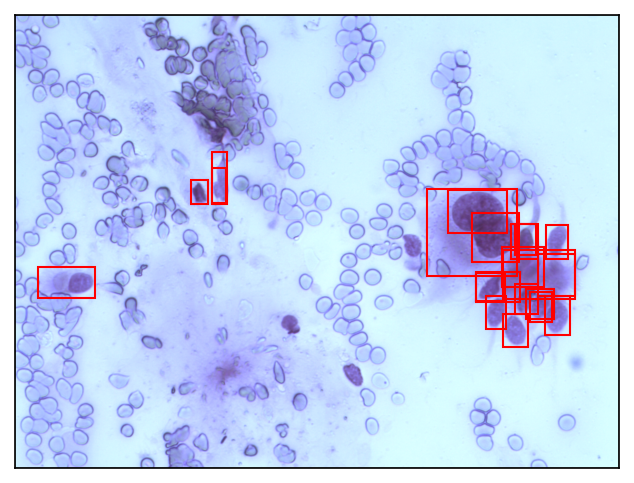

In [7]:
plt.figure(dpi=150)

final_result = model.predict(test_images[0], conf=0.01)[0].boxes.data.cpu().numpy()
img = cv2.imread(test_images[0])

plt.imshow(img)
plt.xticks([]); plt.yticks([]);
ax = plt.gca()

for idx in range(len(final_result)):
    rect = Rectangle((final_result[idx, 0], final_result[idx, 1]),
                     final_result[idx, 2]-final_result[idx, 0],
                     final_result[idx, 3]-final_result[idx, 1],
                     linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

In [8]:
final_result

array([[     1548.4,      671.53,      1707.5,      836.76,     0.87912,           1],
       [     1797.2,      951.32,      1880.8,      1083.1,     0.74225,           1],
       [     1468.5,      592.72,      1667.1,      739.95,     0.60046,           1],
       [       1595,      952.21,      1664.1,      1064.5,     0.48873,           1],
       [     1744.7,      938.93,      1821.1,      1040.4,     0.43018,           1],
       [     1774.1,      811.39,      1897.5,      952.66,      0.3938,           1],
       [     1649.5,      786.38,      1793.6,      920.66,     0.32335,           1],
       [     1652.8,      1011.6,      1740.4,      1124.7,     0.24875,           1],
       [     1693.5,      909.96,      1774.1,      1013.9,     0.21769,           1],
       [     1395.5,      589.19,      1700.4,      885.29,     0.12929,           1],
       [     1733.4,      928.03,      1827.8,      1031.2,    0.083795,           1],
       [     1563.9,      873.71,      1659

In [70]:
!mkdir submit

In [22]:
for path in test_images:
    img = cv2.imread(path)
    final_result = model.predict(img, conf=0.01)[0].boxes.data.cpu().numpy()
    final_result[0] = final_result[0].round()
    final_result[1] = final_result[1].round()
    final_result[2] = final_result[2].round()
    final_result[3] = final_result[3].round()
    
    with open('./submit/' + path.split('/')[-1][:-4] + '.txt', 'w') as up:
        for row in final_result:
            # row = [str(int(x)) for x in row]
            row = list(row)
            row[0] = str(row[0])
            row[1] = str(row[1])
            row[2] = str(row[2])
            row[3] = str(row[3])

            up.write(str(int(row[-1])) + ' ' + str(float(row[-2])) + ' ' + ' '.join(row[:4]) + '\n')


0: 480x640 21 1s, 13.3ms
Speed: 20.7ms preprocess, 13.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 8 1s, 13.2ms
Speed: 2.1ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 48 1s, 13.2ms
Speed: 2.1ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 0, 5 1s, 13.3ms
Speed: 2.0ms preprocess, 13.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 54 1s, 13.2ms
Speed: 2.1ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 10 1s, 13.2ms
Speed: 2.1ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 0, 51 1s, 13.1ms
Speed: 2.1ms preprocess, 13.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 4 0s, 17 1s, 13.2ms
Speed: 2.0ms preprocess, 13.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



In [24]:
!zip -r submit.zip submit

  adding: submit/ (stored 0%)
  adding: submit/2023-04-27-16-45-49-37805_2048-1536.txt (deflated 50%)
  adding: submit/2023-04-27-17-03-38-94218_2048-1536.txt (deflated 51%)
  adding: submit/2023-04-27-17-05-23-11916_2048-1536.txt (deflated 50%)
  adding: submit/2023-07-12-21-46-28-10313_2048-1536.txt (deflated 52%)
  adding: submit/2023-04-27-17-05-02-32021_2048-1536.txt (deflated 51%)
  adding: submit/2023-07-13-03-08-00-09856_2048-1536.txt (deflated 51%)
  adding: submit/2023-07-07-01-30-02-53136_2048-1536.txt (deflated 50%)
  adding: submit/2023-07-12-21-49-48-19633_2048-1536.txt (deflated 49%)
  adding: submit/2023-07-13-02-40-57-15344_2048-1536.txt (deflated 51%)
  adding: submit/2023-07-13-03-09-02-50970_2048-1536.txt (deflated 51%)
  adding: submit/2023-04-27-16-47-00-74000_2048-1536.txt (deflated 48%)
  adding: submit/2023-07-13-03-09-42-30428_2048-1536.txt (deflated 51%)
  adding: submit/2023-04-24-13-41-14-36353_2048-1536.txt (deflated 50%)
  adding: submit/2023-04-24-13-42-